In [1]:
pip install gower

Note: you may need to restart the kernel to use updated packages.


<div style="font-size: 25px">
    
**Задание №1 - Запрос PostrgreSQL:**

`
SELECT sel.install_date, sel.final_date, MAX(sel.payments_sum) AS payments_sum
FROM (SELECT (i.date::date) AS install_date,
       p.date::date AS final_date,
       SUM(p.payment) over (partition by i.date::date order by p.date::date
       rows between unbounded preceding and current row) AS payments_sum
FROM installs AS i
INNER JOIN payments AS p ON i.player_id = p.player_id
WHERE i.date BETWEEN '2019-09-01' AND '2019-09-30'
GROUP BY i.date,p.date, p.payment
ORDER BY install_date, final_date) AS sel
GROUP BY sel.final_date, sel.install_date
ORDER BY sel.install_date, sel.final_date;`

<div style="font-size: 25px">
    
**Задание №2 - Оценка продолжительности сессии после изменения баланса оружия:**


<div style="font-size: 20px">
    
**1. Загрузка данных и предварительный осмотр**

In [2]:
# Загрузим необходимые для дальнейшего анализа библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gower
from sklearn.cluster import KMeans

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
# Загрузим файл и изменим кодировку для корректного отбражения с использованием pandas
df = pd.read_csv('data_test.csv',engine="python", encoding="cp1251")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   battle_id     20000 non-null  int64  
 1   unit_1        20000 non-null  object 
 2   unit_2        20000 non-null  object 
 3   unit_3        20000 non-null  object 
 4   unit_4        20000 non-null  object 
 5   len           20000 non-null  float64
 6   balance_mark  20000 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 1.1+ MB


Проведем осмотр данных на предмет наличия пропусков, полных дубликатов, обпечаток. В осмотре учтём наличие деления на две группы: до и после изменения баланса оружия(before и after).

In [5]:
# Проверим деление данных на 2 группы (до и после изменений)
df.balance_mark.value_counts()

before    10000
after     10000
Name: balance_mark, dtype: int64

In [6]:
# Выделим данные до и после изменения баланса
temp_a = df.query("balance_mark == 'before'")
temp_b = df.query("balance_mark == 'after'")

In [7]:
# Исследуем данные на наличие пропусков
def explore_data(data):
    print(f'Общая информация о датафрейме:')
    print()
    display(data.info())
    print()
    print(f'В датафрейме {data.duplicated().sum()} полных дупликатов, что составляет- {data.duplicated().sum() / len(data)}%.')
    print()
    print(f"Рассмотрим первые 5 строк датафрейма:")
    print()
    display(data.head())
    print()
    print(f'Рассмотрим последние 5 строк датафрейма:')
    display(data.tail())
    print()
    print(f"Рассмотрим выборочно 5 строк:")
    print()
    display(data.sample(5))
    print()
    expl_column = {'unit_1':data.unit_1,'unit_2':data.unit_2, 'unit_3':data.unit_3}
    for key,column in expl_column.items():
        print(f'Уникальные значения колонки по каждой из позиций {key}:\n{column.value_counts()}')
        sns.histplot(data=data, x=data[key], color='purple')
        plt.show()
    print()
    print('--------------------------------------------------------------------------------')
    print('********************************************************************************')
    print('--------------------------------------------------------------------------------')
    print()

**Предварительный осмотр данных до внесения изменений**:

Общая информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   battle_id     10000 non-null  int64  
 1   unit_1        10000 non-null  object 
 2   unit_2        10000 non-null  object 
 3   unit_3        10000 non-null  object 
 4   unit_4        10000 non-null  object 
 5   len           10000 non-null  float64
 6   balance_mark  10000 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 625.0+ KB


None


В датафрейме 0 полных дупликатов, что составляет- 0.0%.

Рассмотрим первые 5 строк датафрейма:



,battle_id,unit_1,unit_2,unit_3,unit_4,len,balance_mark
0,103921,топор,лук,булава,лук,17.35,before
1,117214,посох,посох,лук,лук,21.84,before
2,115502,меч,посох,булава,топор,16.00,before
3,110102,булава,лук,лук,булава,17.22,before
4,104989,меч,посох,булава,посох,19.20,before



Рассмотрим последние 5 строк датафрейма:


,battle_id,unit_1,unit_2,unit_3,unit_4,len,balance_mark
9995,110026,посох,лук,лук,булава,17.88,before
9996,113821,топор,лук,посох,лук,16.26,before
9997,105155,меч,лук,посох,меч,20.58,before
9998,104050,лук,меч,булава,посох,20.08,before
9999,104272,лук,посох,лук,булава,17.40,before



Рассмотрим выборочно 5 строк:



,battle_id,unit_1,unit_2,unit_3,unit_4,len,balance_mark
2532,106850,меч,булава,лук,булава,24.82,before
5598,103266,посох,лук,лук,лук,23.89,before
217,108721,меч,топор,булава,булава,15.94,before
3621,109156,булава,булава,меч,лук,15.89,before
2681,111066,булава,лук,лук,посох,19.44,before



Уникальные значения колонки по каждой из позиций unit_1:
меч       2045
булава    2031
посох     2019
топор     1989
лук       1916
Name: unit_1, dtype: int64


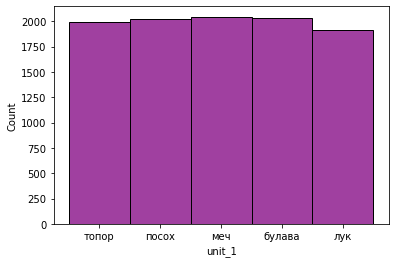

Уникальные значения колонки по каждой из позиций unit_2:
булава    2060
топор     2030
меч       2004
лук       1983
посох     1923
Name: unit_2, dtype: int64


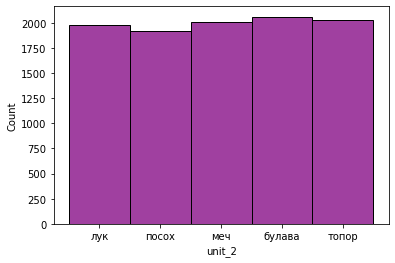

Уникальные значения колонки по каждой из позиций unit_3:
лук       2051
булава    2024
меч       2012
топор     1974
посох     1939
Name: unit_3, dtype: int64


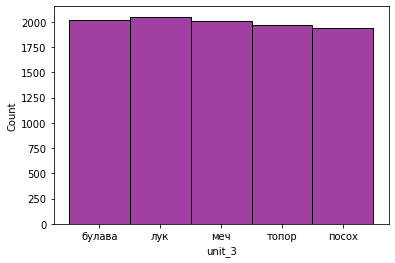


--------------------------------------------------------------------------------
********************************************************************************
--------------------------------------------------------------------------------



In [8]:
explore_data(temp_a)

**Предварительный осмотр данных после внесения изменений**:

Общая информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 10000 to 19999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   battle_id     10000 non-null  int64  
 1   unit_1        10000 non-null  object 
 2   unit_2        10000 non-null  object 
 3   unit_3        10000 non-null  object 
 4   unit_4        10000 non-null  object 
 5   len           10000 non-null  float64
 6   balance_mark  10000 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 625.0+ KB


None


В датафрейме 0 полных дупликатов, что составляет- 0.0%.

Рассмотрим первые 5 строк датафрейма:



,battle_id,unit_1,unit_2,unit_3,unit_4,len,balance_mark
10000,103978,меч,булава,меч,булава,23.30,after
10001,108601,посох,топор,булава,топор,27.12,after
10002,112054,лук,булава,лук,лук,26.06,after
10003,119433,посох,посох,лук,булава,22.76,after
10004,119938,меч,посох,топор,посох,28.40,after



Рассмотрим последние 5 строк датафрейма:


,battle_id,unit_1,unit_2,unit_3,unit_4,len,balance_mark
19995,108834,посох,булава,лук,посох,26.37,after
19996,119941,посох,меч,лук,посох,23.73,after
19997,112911,топор,посох,булава,топор,27.73,after
19998,111684,меч,топор,посох,меч,24.20,after
19999,103437,лук,лук,булава,булава,22.83,after



Рассмотрим выборочно 5 строк:



,battle_id,unit_1,unit_2,unit_3,unit_4,len,balance_mark
18904,103821,топор,лук,булава,посох,28.38,after
16490,115440,посох,топор,булава,меч,22.13,after
11849,104090,топор,лук,меч,меч,21.48,after
17858,108704,топор,посох,булава,топор,27.69,after
14947,101392,лук,посох,меч,посох,25.73,after



Уникальные значения колонки по каждой из позиций unit_1:
лук       2066
топор     2043
меч       2008
булава    1995
посох     1888
Name: unit_1, dtype: int64


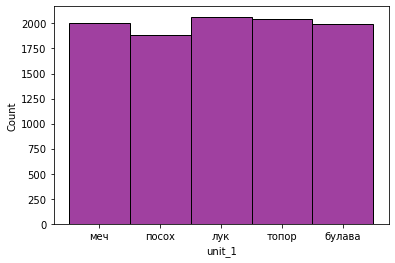

Уникальные значения колонки по каждой из позиций unit_2:
булава    2071
лук       2000
меч       1997
посох     1967
топор     1965
Name: unit_2, dtype: int64


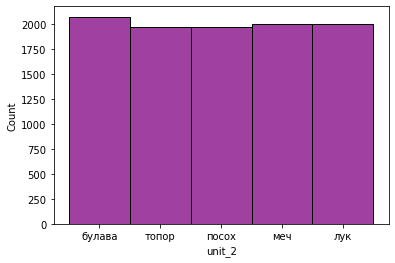

Уникальные значения колонки по каждой из позиций unit_3:
булава    2044
меч       2013
посох     2003
лук       1975
топор     1965
Name: unit_3, dtype: int64


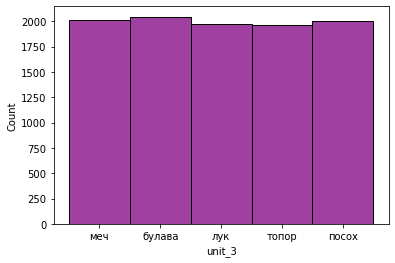


--------------------------------------------------------------------------------
********************************************************************************
--------------------------------------------------------------------------------



In [9]:
explore_data(temp_b)

<div style="font-size: 20px">
    
**Промежуточные выводы:**

Предварительныцй осмотр датасета позволяет отметить следующее:

1) данные описаны 20 000 строками и 7 колонками датасета, включающими сведения об уникальном id боя, типе оружия каждого бойца(для каждого из 4), длительности боя, а также о моменте сбора данных боя(до или после изменения баланса оружия);

2) полные дубликаты, пропуски, опечатки отсутствуют предобработка в указанной части не требуется;

<div style="font-size: 20px">
    
**2. Выделение подгрупп**

Полагаю, что для корректного анализа наличия/отсутствия именения продолжительности сессии пользователей после внесения изменений в баланс оружия, **следует сравнивать не только данные всего датасета, но и конкретно по каждой группе пользователей**. Для выделения групп пользователей воспользуемся методом кластеризации **K-Means**, предварительно преобразовав категориальные данные в численные методом **One-hot encoding**.

In [10]:
# Посмотрим общие сведения относительно продолжительности сессии групп до и после изменений
# без выделения подгрупп в зависимости от комбинации использованного оружия
display('Основные показатели колонки len, для данных до изменения баланса оружия',round(temp_a['len'].describe().T, 2))

'Основные показатели колонки len, для данных до изменения баланса оружия'

count    10000.00
mean        19.97
std          2.88
min         15.00
25%         17.51
50%         19.96
75%         22.46
max         25.00
Name: len, dtype: float64

In [11]:
display('Основные показатели колонки len, для данных после изменения баланса оружия',round(temp_b['len'].describe().T, 2))

'Основные показатели колонки len, для данных после изменения баланса оружия'

count    10000.00
mean        24.12
std          3.80
min          5.01
25%         21.71
50%         24.30
75%         27.09
max         30.00
Name: len, dtype: float64

<div style="font-size: 15px">
    
**Выводы:**

В результате сравнения показателей выборок до и после изменения баланса оружия (до выделения подгрупп), можно отметить следующее:

1) средняя и максимальна продолжительнось сессий увеличились(на 4-5 минут.);

2) стандартное отклонение увеличилось, примерно, на 1 минуту;

3) произошло увеличение значений всех кванитлей на 4-5 минут;

4) в три раза снизилось минимальная продолжительность сессии(с 15 до 5 минут).

**Определим оптимальное количество кластеров методом "Локтя" (Elbow method)**

Поскольку у нас имеются смешанные данные(категориальные и числовые), применение метода "Локтя" напрямую невозможно. Для осуществления дальнейшей кластеризации необходимо преобразовать категориальные данные используя метод OHE.

In [12]:
# OHE для датасета до изменения баланса оружия
df_new = pd.get_dummies(df, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)

df_new.sample(5)

,battle_id,len,unit_1_булава,unit_1_лук,unit_1_меч,unit_1_посох,unit_1_топор,unit_2_булава,unit_2_лук,unit_2_меч,...,unit_3_меч,unit_3_посох,unit_3_топор,unit_4_булава,unit_4_лук,unit_4_меч,unit_4_посох,unit_4_топор,balance_mark_after,balance_mark_before
3697,105379,17.46,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
16679,108518,26.25,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
5871,105640,23.45,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
3686,111476,20.32,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
6772,107492,16.03,0,0,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1


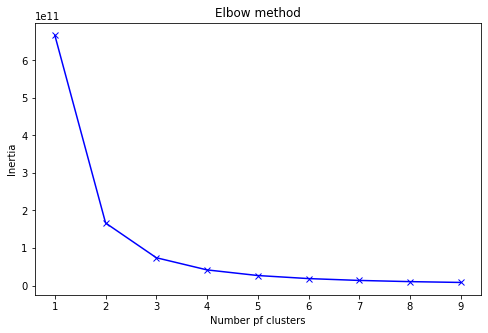

In [13]:
def elbow_meth(data):
    distortion = []
    K = range(1,10)

    for k in K:
        model = KMeans(n_clusters=k, random_state=12345)
        model.fit(data)
        distortion.append(model.inertia_)
    
    # Визуализируем показатели
    plt.figure(figsize=(8,5))
    plt.plot(K, distortion, 'bx-')
    plt.xlabel('Number pf clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow method')
    plt.show()

elbow_meth(df_new)

Исходя изграфиков метода "Локтя", как для данных до изменения баланса, так и после целесообразно использовать деление на **три кластера**. Выведим наиболее **характерные признаки** каждого из класторов.

In [14]:
# Типичный представитель
model = KMeans(n_clusters=3, random_state=12345)
model.fit(df_new)
print("Типичный представитель сегментов для 3-х кластеров:")
print(model.cluster_centers_.round())

Типичный представитель сегментов для 3-х кластеров:
[[1.10002e+05 2.20000e+01 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00]
 [1.16669e+05 2.20000e+01 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00]
 [1.03333e+05 2.20000e+01 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00]]


In [15]:
pred = model.predict(df_new.iloc[:,:24])
frame = pd.DataFrame(df)
frame['cluster'] = pred
frame.sample(5)

,battle_id,unit_1,unit_2,unit_3,unit_4,len,balance_mark,cluster
3653,109488,булава,булава,лук,лук,24.78,before,0
8092,117045,посох,посох,меч,посох,23.28,before,1
18155,103523,меч,лук,топор,лук,23.69,after,2
634,112344,булава,топор,лук,топор,15.51,before,0
12591,116976,посох,посох,топор,лук,20.08,after,1


In [16]:
frame['cluster'].value_counts()

2    6668
0    6667
1    6665
Name: cluster, dtype: int64

<div style="font-size: 20px">
    
**3. Анализ изменений в подгруппах:**

In [17]:
# Проанализируем соответсвующие подгруппы до и после внсения изменений в баланс оружия
temp_new_a = frame.query("balance_mark == 'before'")

temp_new_b = frame.query("balance_mark == 'after'")

clusters = {'0_before':temp_new_a.query("cluster==0"),
            '0_after':temp_new_b.query("cluster==0"),
            '1_before':temp_new_a.query("cluster==1"),
            '1_after':temp_new_b.query("cluster==1"),
            '2_before':temp_new_a.query("cluster==2"),
            '2_after':temp_new_b.query("cluster==2")}

'Основные показатели колонки len, для 0_before подгруппы до изменения баланса оружия'

count    3341.00
mean       19.96
std         2.86
min        15.01
25%        17.48
50%        19.96
75%        22.39
max        25.00
Name: len, dtype: float64

'Основные показатели колонки len, для 0_after подгруппы до изменения баланса оружия'

count    3326.00
mean       24.14
std         3.69
min         5.59
25%        21.72
50%        24.26
75%        27.00
max        29.98
Name: len, dtype: float64

'Основные показатели колонки len, для 1_before подгруппы до изменения баланса оружия'

count    3338.00
mean       19.94
std         2.92
min        15.00
25%        17.44
50%        19.94
75%        22.49
max        25.00
Name: len, dtype: float64

'Основные показатели колонки len, для 1_after подгруппы до изменения баланса оружия'

count    3327.00
mean       24.17
std         3.89
min         5.05
25%        21.71
50%        24.39
75%        27.24
max        30.00
Name: len, dtype: float64

'Основные показатели колонки len, для 2_before подгруппы до изменения баланса оружия'

count    3321.00
mean       20.02
std         2.85
min        15.00
25%        17.55
50%        20.01
75%        22.50
max        25.00
Name: len, dtype: float64

'Основные показатели колонки len, для 2_after подгруппы до изменения баланса оружия'

count    3347.00
mean       24.07
std         3.82
min         5.01
25%        21.69
50%        24.25
75%        26.93
max        29.99
Name: len, dtype: float64

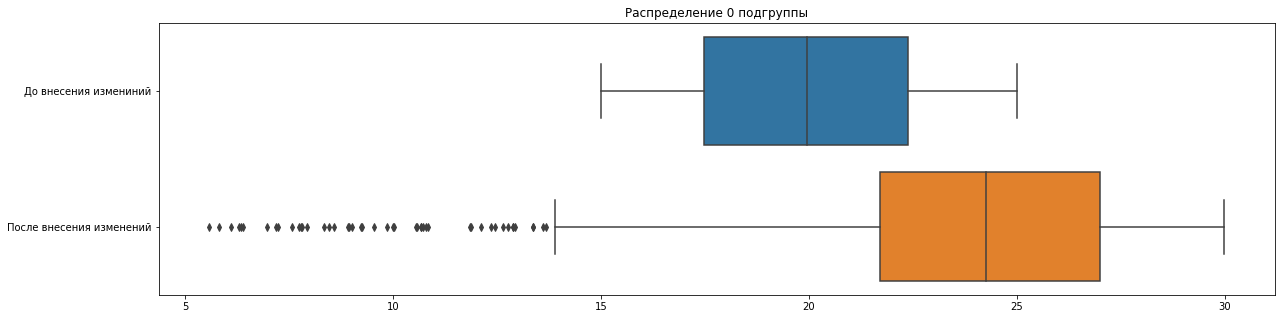

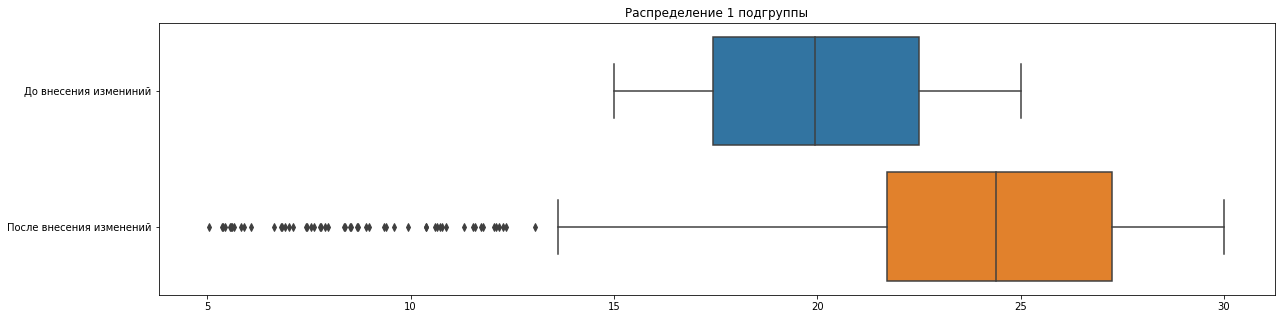

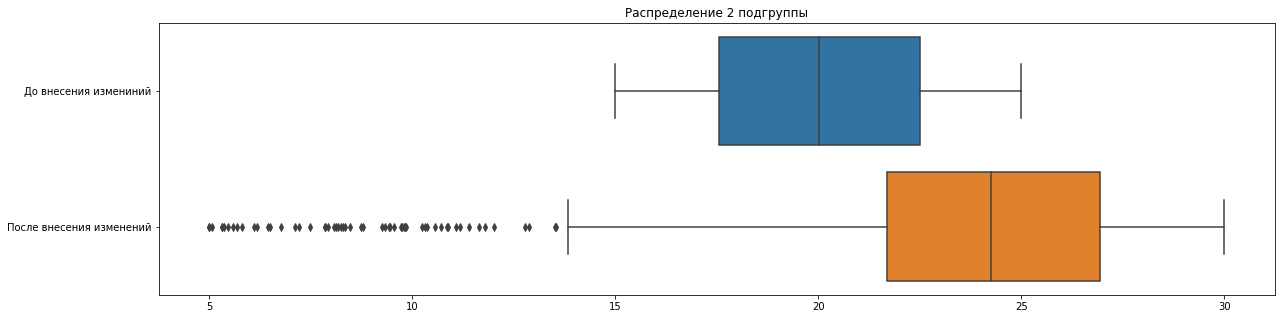

In [18]:


def visual_subgroups(clusters):
    # Рассмотрим основные показатели и визуализируем средние значения
    for key, value in clusters.items():
        print()
        display(f'Основные показатели колонки len, для {key} подгруппы до изменения баланса оружия',round(value['len'].describe().T, 2))
        print()
    
    # Boxplot
    for i in range(3):
        temp_1 = temp_new_a.query('cluster == @i')
        temp_2 = temp_new_b.query('cluster == @i')
        analize = pd.DataFrame({
        'До внесения измениний':temp_1['len'],
        'После внесения изменений':temp_2['len']})
        plt.figure(figsize=(20,5))
        sns.boxplot(data=analize, orient="h")
        plt.title(f'Распределение {i} подгруппы')
        plt.show()
     
        
visual_subgroups(clusters)

<div style="font-size: 20px">
    
**Итоговые выводы:**

Изменение баланса оружия привело к увеличению продолжительности боя на 4-5 минут. Кроме того, следует отметить, что:

1) увеличился разброс значений каждой из выделенных в результате применения кластеризации подгрупп

2) появились выбросы во всех подгруппах, а также сократилась минимальная продолжительность боя.

На последний факт следует обратить особое внимание, поскольку он может свидетельствовать о том, что:

а) в результате изменения баланса произошло усложнение прохождение боя пользователя, и он бросает играть на первых минутах, что в конечном счёте ведёт к оттоку пользователей

б) произошло упрощение игры, что можно использовать для дополнительного усложнения в целях увеличения сессии пользователя

<div style="font-size: 20px">
    
**Задача №3 - Вероятность получения полного сета**

P(S1) - вероятность выпадения предметов 1-го типа хотя бы раз

P(S2) - вероятность выпадения предметов 2-го типа хотя бы раз

P(S3) - вероятность выпадения предметов 3-го типа хотя бы раз

n - число попыток достать предмет

p - вероятность вытащить предмет 1-го типа в каждой из попыток(аналогично для 2-го и 3-его)

k >= 1 - получиение хотя бы 1 раз предмет 1-го типа(аналогично для 2-го и 3-его)

k = 0 - не получиение предмет 1-го типа ни разу (аналогично для 2-го и 3-его)

P6(0) = (1/3)^0 * (1-1/3)^6 = (2/3)^6

P(S1) = P6(k>=1) = 1 - P6(0) = 1-(2/3)^6 = 0.9122 - вероятность выпадения предмета 1-го типа хотя бы раз(аналогично для 2-го и 3-го типа)

Итоговая вероятность: P(S1) * P(S2) * P(S3) = 0.9122 * 0.8683 * 0.8025 = 0.6356 = 64% 